# Fast training with MONAI features

This tutorial shows a regular PyTorch training program and a MONAI optimized training program, and compared the performance.  
Mainly includes:
1. AMP (Auto mixed precision).
2. CacheDataset for deterministic transforms.
3. Move data to GPU and cache, then execute random transforms on GPU.
4. multi-threads `ThreadDataLoader` is faster than PyTorch DataLoader in light-weight task.
5. Use MONAI `DiceCE` loss instead of regular `Dice` loss.
6. Use MONAI `Novograd` optimizer instead of regular `Adam` optimizer.

With a V100 GPU, we are able to obtain approximately `12x` speedup compared with a Pytorch native implementation when the training converges at a validation mean dice of `0.95`.

It's modified from the Spleen 3D segmentation tutorial notebook, the Spleen dataset can be downloaded from http://medicaldecathlon.com/.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/acceleration/fast_training_tutorial.ipynb)

## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import math
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    Dataset,
    decollate_batch,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.optimizers import Novograd
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    Compose,
    CropForegroundd,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToDeviced,
    EnsureTyped,
    EnsureType,
)
from monai.utils import get_torch_version_tuple, set_determinism

print_config()

if get_torch_version_tuple() < (1, 6):
    raise RuntimeError(
        "AMP feature only exists in PyTorch version greater than v1.6."
    )

MONAI version: 0.4.0+618.g69b44596
Numpy version: 1.20.3
Pytorch version: 1.9.0a0+c3d40fd
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 69b4459650fb6943b9e729e724254d2db2b2a1f2

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0a0
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /workspace/data/medical


## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [5]:
train_images = sorted(
    glob.glob(os.path.join(data_root, "imagesTr", "*.nii.gz"))
)
train_labels = sorted(
    glob.glob(os.path.join(data_root, "labelsTr", "*.nii.gz"))
)
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation

In [10]:
def transformations(fast=False):
    train_transforms = [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # pre-compute foreground and background indexes
        # and cache them to accelerate training
        FgBgToIndicesd(
            keys="label",
            fg_postfix="_fg",
            bg_postfix="_bg",
            image_key="image",
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
    if fast:
        # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
        train_transforms.append(
            ToDeviced(keys=["image", "label"], device="cuda:0")
        )
    train_transforms.append(
        # randomly crop out patch samples from big
        # image based on pos / neg ratio
        # the image centers of negative samples
        # must be in valid image area
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            fg_indices_key="label_fg",
            bg_indices_key="label_bg",
        )
    )

    val_transforms = [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
    if fast:
        # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
        val_transforms.append(
            ToDeviced(keys=["image", "label"], device="cuda:0")
        )

    return Compose(train_transforms), Compose(val_transforms)

## Define the training progress
For a typical PyTorch regular training procedure, use regular `Dataset`, `DataLoader`, `Adam` optimizer and `Dice` loss to train the model.

For MONAI fast training progress, we mainly introduce the following features:
1. `AMP` (auto mixed precision): AMP is an important feature released in PyTorch v1.6, NVIDIA CUDA 11 added strong support for AMP and significantly improved training speed.
2. `CacheDataset`: Dataset with the cache mechanism that can load data and cache deterministic transforms' result during training.
3. `ToDeviced` transform: to move data to GPU and cache with `CacheDataset`, then execute random transforms on GPU directly, avoid CPU -> GPU sync in every epoch. Please note that not all the MONAI transforms support GPU operation so far, still working in progress.
4. `ThreadDataLoader`: uses multi-threads instead of multi-processing, faster than `DataLoader` in light-weight task as we already cached the results of most computation.
5. `Novograd` optimizer: Novograd is based on the paper "Stochastic Gradient Methods with Layer-wise Adaptive Moments for Training of Deep Networks" `<https://arxiv.org/pdf/1905.11286.pdf>`.
6. `DiceCE` loss function: computes Dice loss and Cross Entropy Loss, returns the weighted sum of these two losses.

In [11]:
def train_process(fast=False):
    max_epochs = 200
    learning_rate = 1e-4
    val_interval = 1  # do validation for every epoch

    train_trans, val_trans = transformations(fast=fast)
    # set CacheDataset, ThreadDataLoader and DiceCE loss for MONAI fast training
    if fast:
        train_ds = CacheDataset(
            data=train_files,
            transform=train_trans,
            cache_rate=1.0,
            num_workers=8,
        )
        val_ds = CacheDataset(
            data=val_files, transform=val_trans, cache_rate=1.0, num_workers=5
        )
        # disable multi-workers because `ThreadDataLoader` works with multi-threads
        train_loader = DataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)
        val_loader = DataLoader(val_ds, num_workers=0, batch_size=1)
        loss_function = DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, batch=True)
    else:
        train_ds = Dataset(data=train_files, transform=train_trans)
        val_ds = Dataset(data=val_files, transform=val_trans)
        loader_workers = 4
        # num_worker=4 is the best parameter according to the test
        train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
        loss_function = DiceLoss(to_onehot_y=True, softmax=True)

    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

    # set Novograd optimizer for MONAI training
    if fast:
        # Novograd paper suggests to use a bigger LR than Adam,
        # because Adam does normalization by element-wise second moments
        optimizer = Novograd(model.parameters(), learning_rate * 10)
        scaler = torch.cuda.amp.GradScaler()
    else:
        optimizer = Adam(model.parameters(), learning_rate)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()
    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            # set AMP for MONAI training
            if fast:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            epoch_loss += loss.item()
            epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)
            print(
                f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
                f" step time: {(time.time() - step_start):.4f}"
            )
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    # set AMP for MONAI validation
                    if fast:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(
                                val_inputs, roi_size, sw_batch_size, model
                            )
                    else:
                        val_outputs = sliding_window_inference(
                            val_inputs, roi_size, sw_batch_size, model
                        )
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    dice_metric(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_metrics_epochs_and_time[0].append(best_metric)
                    best_metrics_epochs_and_time[1].append(best_metric_epoch)
                    best_metrics_epochs_and_time[2].append(
                        time.time() - total_start
                    )
                    torch.save(model.state_dict(), "best_metric_model.pth")
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current"
                    f" mean dice: {metric:.4f}"
                    f" best mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )
        print(
            f"time consuming of epoch {epoch + 1} is:"
            f" {(time.time() - epoch_start):.4f}"
        )
        epoch_times.append(time.time() - epoch_start)

    total_time = time.time() - total_start
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {total_time:.4f}"
    )
    return (
        max_epochs,
        epoch_loss_values,
        metric_values,
        epoch_times,
        best_metrics_epochs_and_time,
        total_time,
    )

## Enable determinism and execute regular PyTorch training

In [13]:
set_determinism(seed=0)
regular_start = time.time()
(
    epoch_num,
    epoch_loss_values,
    metric_values,
    epoch_times,
    best,
    train_time,
) = train_process(fast=False)
total_time = time.time() - regular_start
print(
    f"total time of {epoch_num} epochs with regular PyTorch training: {total_time:.4f}"
)

----------
epoch 1/200
1/8, train_loss: 0.6697 step time: 1.0687
2/8, train_loss: 0.6873 step time: 1.0706
3/8, train_loss: 0.6945 step time: 1.0534
4/8, train_loss: 0.6831 step time: 1.0570
5/8, train_loss: 0.6724 step time: 1.0698
6/8, train_loss: 0.6819 step time: 1.0536
7/8, train_loss: 0.6689 step time: 1.0551
8/8, train_loss: 0.6769 step time: 1.0490
epoch 1 average loss: 0.6794
saved new best metric model
current epoch: 1 current mean dice: 0.0337 best mean dice: 0.0337 at epoch: 1
time consuming of epoch 1 is: 54.2812
----------
epoch 2/200
1/8, train_loss: 0.6560 step time: 1.0731
2/8, train_loss: 0.6650 step time: 1.0578
3/8, train_loss: 0.6669 step time: 1.0670
4/8, train_loss: 0.6687 step time: 1.0529
5/8, train_loss: 0.6566 step time: 1.0475
6/8, train_loss: 0.6485 step time: 1.0531
7/8, train_loss: 0.6636 step time: 1.0527
8/8, train_loss: 0.6602 step time: 1.0529
epoch 2 average loss: 0.6607
saved new best metric model
current epoch: 2 current mean dice: 0.1365 best mean

6/8, train_loss: 0.5895 step time: 1.0475
7/8, train_loss: 0.5439 step time: 1.0516
8/8, train_loss: 0.5406 step time: 1.0508
epoch 16 average loss: 0.5709
current epoch: 16 current mean dice: 0.4655 best mean dice: 0.4754 at epoch: 15
time consuming of epoch 16 is: 54.5414
----------
epoch 17/200
1/8, train_loss: 0.5796 step time: 1.0726
2/8, train_loss: 0.5936 step time: 1.0537
3/8, train_loss: 0.5680 step time: 1.0556
4/8, train_loss: 0.5198 step time: 1.0587
5/8, train_loss: 0.5886 step time: 1.0596
6/8, train_loss: 0.5724 step time: 1.0496
7/8, train_loss: 0.5643 step time: 1.0501
8/8, train_loss: 0.5902 step time: 1.0522
epoch 17 average loss: 0.5721
saved new best metric model
current epoch: 17 current mean dice: 0.4852 best mean dice: 0.4852 at epoch: 17
time consuming of epoch 17 is: 53.4772
----------
epoch 18/200
1/8, train_loss: 0.5613 step time: 1.0818
2/8, train_loss: 0.5912 step time: 1.0627
3/8, train_loss: 0.5903 step time: 1.0579
4/8, train_loss: 0.5821 step time: 1.0

6/8, train_loss: 0.4773 step time: 1.0518
7/8, train_loss: 0.4931 step time: 1.0525
8/8, train_loss: 0.5285 step time: 1.0529
epoch 32 average loss: 0.5053
current epoch: 32 current mean dice: 0.4591 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 32 is: 56.5967
----------
epoch 33/200
1/8, train_loss: 0.5211 step time: 1.0803
2/8, train_loss: 0.5278 step time: 1.0593
3/8, train_loss: 0.4822 step time: 1.0620
4/8, train_loss: 0.5038 step time: 1.0532
5/8, train_loss: 0.4874 step time: 1.0480
6/8, train_loss: 0.4669 step time: 1.0524
7/8, train_loss: 0.4824 step time: 1.0522
8/8, train_loss: 0.4711 step time: 1.0499
epoch 33 average loss: 0.4928
current epoch: 33 current mean dice: 0.4628 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 33 is: 60.6244
----------
epoch 34/200
1/8, train_loss: 0.4743 step time: 1.0757
2/8, train_loss: 0.5226 step time: 1.0536
3/8, train_loss: 0.4708 step time: 1.0631
4/8, train_loss: 0.4776 step time: 1.0627
5/8, train_loss: 0.4797 

8/8, train_loss: 0.4752 step time: 1.0526
epoch 48 average loss: 0.4372
current epoch: 48 current mean dice: 0.3902 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 48 is: 56.8804
----------
epoch 49/200
1/8, train_loss: 0.4356 step time: 1.0721
2/8, train_loss: 0.4162 step time: 1.0526
3/8, train_loss: 0.4379 step time: 1.0474
4/8, train_loss: 0.4664 step time: 1.0572
5/8, train_loss: 0.4720 step time: 1.0471
6/8, train_loss: 0.4055 step time: 1.0508
7/8, train_loss: 0.4461 step time: 1.0527
8/8, train_loss: 0.3946 step time: 1.0524
epoch 49 average loss: 0.4343
current epoch: 49 current mean dice: 0.5003 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 49 is: 54.2914
----------
epoch 50/200
1/8, train_loss: 0.4212 step time: 1.0798
2/8, train_loss: 0.4123 step time: 1.0585
3/8, train_loss: 0.4414 step time: 1.0603
4/8, train_loss: 0.4172 step time: 1.0553
5/8, train_loss: 0.3957 step time: 1.0480
6/8, train_loss: 0.3891 step time: 1.0521
7/8, train_loss: 0.4161 

current epoch: 64 current mean dice: 0.3724 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 64 is: 55.4245
----------
epoch 65/200
1/8, train_loss: 0.4454 step time: 1.0791
2/8, train_loss: 0.3523 step time: 1.0654
3/8, train_loss: 0.3918 step time: 1.0537
4/8, train_loss: 0.3182 step time: 1.0557
5/8, train_loss: 0.4322 step time: 1.0633
6/8, train_loss: 0.3618 step time: 1.0474
7/8, train_loss: 0.3967 step time: 1.0483
8/8, train_loss: 0.3679 step time: 1.0518
epoch 65 average loss: 0.3833
current epoch: 65 current mean dice: 0.4085 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 65 is: 54.1172
----------
epoch 66/200
1/8, train_loss: 0.3788 step time: 1.0655
2/8, train_loss: 0.3553 step time: 1.0557
3/8, train_loss: 0.3515 step time: 1.0538
4/8, train_loss: 0.4471 step time: 1.0553
5/8, train_loss: 0.3707 step time: 1.0531
6/8, train_loss: 0.4129 step time: 1.0526
7/8, train_loss: 0.4053 step time: 1.0497
8/8, train_loss: 0.3533 step time: 1.0510
epoch 66 ave

1/8, train_loss: 0.3154 step time: 1.0862
2/8, train_loss: 0.4589 step time: 1.0578
3/8, train_loss: 0.3456 step time: 1.0589
4/8, train_loss: 0.3924 step time: 1.0549
5/8, train_loss: 0.3785 step time: 1.0487
6/8, train_loss: 0.3823 step time: 1.0523
7/8, train_loss: 0.3398 step time: 1.0530
8/8, train_loss: 0.3614 step time: 1.0526
epoch 81 average loss: 0.3718
current epoch: 81 current mean dice: 0.3275 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 81 is: 56.6417
----------
epoch 82/200
1/8, train_loss: 0.3106 step time: 1.0710
2/8, train_loss: 0.4365 step time: 1.0697
3/8, train_loss: 0.3427 step time: 1.0616
4/8, train_loss: 0.3772 step time: 1.0555
5/8, train_loss: 0.3268 step time: 1.0597
6/8, train_loss: 0.3636 step time: 1.0534
7/8, train_loss: 0.3286 step time: 1.0484
8/8, train_loss: 0.3064 step time: 1.0529
epoch 82 average loss: 0.3490
current epoch: 82 current mean dice: 0.4989 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 82 is: 55.1363
------

3/8, train_loss: 0.2965 step time: 1.0466
4/8, train_loss: 0.3003 step time: 1.0466
5/8, train_loss: 0.3498 step time: 1.0453
6/8, train_loss: 0.3078 step time: 1.0434
7/8, train_loss: 0.2334 step time: 1.0386
8/8, train_loss: 0.3537 step time: 1.0388
epoch 97 average loss: 0.3147
current epoch: 97 current mean dice: 0.3961 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 97 is: 58.6969
----------
epoch 98/200
1/8, train_loss: 0.2471 step time: 1.0662
2/8, train_loss: 0.3259 step time: 1.0571
3/8, train_loss: 0.2566 step time: 1.0467
4/8, train_loss: 0.2756 step time: 1.0581
5/8, train_loss: 0.2810 step time: 1.0537
6/8, train_loss: 0.2970 step time: 1.0577
7/8, train_loss: 0.3060 step time: 1.0506
8/8, train_loss: 0.2963 step time: 1.0492
epoch 98 average loss: 0.2857
current epoch: 98 current mean dice: 0.4343 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 98 is: 54.1843
----------
epoch 99/200
1/8, train_loss: 0.2847 step time: 1.0784
2/8, train_loss: 0.3129 

3/8, train_loss: 0.2427 step time: 1.0561
4/8, train_loss: 0.3173 step time: 1.0517
5/8, train_loss: 0.2549 step time: 1.0502
6/8, train_loss: 0.2449 step time: 1.0510
7/8, train_loss: 0.2625 step time: 1.0515
8/8, train_loss: 0.2732 step time: 1.0482
epoch 113 average loss: 0.2738
current epoch: 113 current mean dice: 0.3598 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 113 is: 53.5144
----------
epoch 114/200
1/8, train_loss: 0.2803 step time: 1.0739
2/8, train_loss: 0.2619 step time: 1.0498
3/8, train_loss: 0.3051 step time: 1.0488
4/8, train_loss: 0.2460 step time: 1.0606
5/8, train_loss: 0.2834 step time: 1.0474
6/8, train_loss: 0.3405 step time: 1.0478
7/8, train_loss: 0.2875 step time: 1.0430
8/8, train_loss: 0.3429 step time: 1.0446
epoch 114 average loss: 0.2935
current epoch: 114 current mean dice: 0.4349 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 114 is: 54.4646
----------
epoch 115/200
1/8, train_loss: 0.2146 step time: 1.0947
2/8, train_loss:

3/8, train_loss: 0.3034 step time: 1.0559
4/8, train_loss: 0.2783 step time: 1.0541
5/8, train_loss: 0.2743 step time: 1.0499
6/8, train_loss: 0.2011 step time: 1.0527
7/8, train_loss: 0.4195 step time: 1.0544
8/8, train_loss: 0.2880 step time: 1.0476
epoch 129 average loss: 0.2872
current epoch: 129 current mean dice: 0.4221 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 129 is: 56.9209
----------
epoch 130/200
1/8, train_loss: 0.2385 step time: 1.0774
2/8, train_loss: 0.2621 step time: 1.0564
3/8, train_loss: 0.3098 step time: 1.0563
4/8, train_loss: 0.3352 step time: 1.0463
5/8, train_loss: 0.2461 step time: 1.0490
6/8, train_loss: 0.2975 step time: 1.0486
7/8, train_loss: 0.2404 step time: 1.0491
8/8, train_loss: 0.2863 step time: 1.0480
epoch 130 average loss: 0.2770
current epoch: 130 current mean dice: 0.4089 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 130 is: 54.6220
----------
epoch 131/200
1/8, train_loss: 0.3214 step time: 1.0789
2/8, train_loss:

3/8, train_loss: 0.2659 step time: 1.0576
4/8, train_loss: 0.2723 step time: 1.0624
5/8, train_loss: 0.2672 step time: 1.0617
6/8, train_loss: 0.2471 step time: 1.0479
7/8, train_loss: 0.2763 step time: 1.0490
8/8, train_loss: 0.2905 step time: 1.0528
epoch 145 average loss: 0.2666
current epoch: 145 current mean dice: 0.3497 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 145 is: 55.2710
----------
epoch 146/200
1/8, train_loss: 0.2077 step time: 1.0863
2/8, train_loss: 0.2594 step time: 1.0521
3/8, train_loss: 0.3467 step time: 1.0540
4/8, train_loss: 0.2158 step time: 1.0563
5/8, train_loss: 0.2818 step time: 1.0512
6/8, train_loss: 0.3338 step time: 1.0578
7/8, train_loss: 0.2785 step time: 1.0496
8/8, train_loss: 0.2781 step time: 1.0527
epoch 146 average loss: 0.2752
current epoch: 146 current mean dice: 0.3904 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 146 is: 56.8902
----------
epoch 147/200
1/8, train_loss: 0.2689 step time: 1.0776
2/8, train_loss:

3/8, train_loss: 0.2252 step time: 1.0635
4/8, train_loss: 0.2394 step time: 1.0491
5/8, train_loss: 0.2417 step time: 1.0516
6/8, train_loss: 0.2126 step time: 1.0489
7/8, train_loss: 0.3055 step time: 1.0530
8/8, train_loss: 0.2113 step time: 1.0513
epoch 161 average loss: 0.2431
current epoch: 161 current mean dice: 0.3857 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 161 is: 55.5485
----------
epoch 162/200
1/8, train_loss: 0.1732 step time: 1.0709
2/8, train_loss: 0.2236 step time: 1.0724
3/8, train_loss: 0.1912 step time: 1.0606
4/8, train_loss: 0.3014 step time: 1.0550
5/8, train_loss: 0.2803 step time: 1.0530
6/8, train_loss: 0.2953 step time: 1.0487
7/8, train_loss: 0.2334 step time: 1.0518
8/8, train_loss: 0.1836 step time: 1.0484
epoch 162 average loss: 0.2353
current epoch: 162 current mean dice: 0.3599 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 162 is: 58.2898
----------
epoch 163/200
1/8, train_loss: 0.2833 step time: 1.0660
2/8, train_loss:

3/8, train_loss: 0.2998 step time: 1.0553
4/8, train_loss: 0.2885 step time: 1.0543
5/8, train_loss: 0.2130 step time: 1.0518
6/8, train_loss: 0.2769 step time: 1.0552
7/8, train_loss: 0.2250 step time: 1.0502
8/8, train_loss: 0.1931 step time: 1.0529
epoch 177 average loss: 0.2488
current epoch: 177 current mean dice: 0.4299 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 177 is: 55.6622
----------
epoch 178/200
1/8, train_loss: 0.1987 step time: 1.0733
2/8, train_loss: 0.3084 step time: 1.0544
3/8, train_loss: 0.3052 step time: 1.0556
4/8, train_loss: 0.1931 step time: 1.0589
5/8, train_loss: 0.1873 step time: 1.0510
6/8, train_loss: 0.1945 step time: 1.0512
7/8, train_loss: 0.2670 step time: 1.0496
8/8, train_loss: 0.2383 step time: 1.0522
epoch 178 average loss: 0.2366
current epoch: 178 current mean dice: 0.3865 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 178 is: 54.0513
----------
epoch 179/200
1/8, train_loss: 0.2584 step time: 1.0678
2/8, train_loss:

3/8, train_loss: 0.2646 step time: 1.0593
4/8, train_loss: 0.1597 step time: 1.0635
5/8, train_loss: 0.1914 step time: 1.0526
6/8, train_loss: 0.3384 step time: 1.0417
7/8, train_loss: 0.2051 step time: 1.0464
8/8, train_loss: 0.1922 step time: 1.0523
epoch 193 average loss: 0.2262
current epoch: 193 current mean dice: 0.3428 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 193 is: 53.8747
----------
epoch 194/200
1/8, train_loss: 0.1730 step time: 1.0710
2/8, train_loss: 0.3366 step time: 1.0669
3/8, train_loss: 0.2127 step time: 1.0559
4/8, train_loss: 0.3358 step time: 1.0528
5/8, train_loss: 0.2722 step time: 1.0511
6/8, train_loss: 0.2034 step time: 1.0537
7/8, train_loss: 0.1904 step time: 1.0491
8/8, train_loss: 0.2717 step time: 1.0491
epoch 194 average loss: 0.2495
current epoch: 194 current mean dice: 0.3685 best mean dice: 0.5103 at epoch: 25
time consuming of epoch 194 is: 54.0772
----------
epoch 195/200
1/8, train_loss: 0.1621 step time: 1.0745
2/8, train_loss:

## Enable determinism and execute MONAI optimized training

In [12]:
set_determinism(seed=0)
monai_start = time.time()
(
    epoch_num,
    m_epoch_loss_values,
    m_metric_values,
    m_epoch_times,
    m_best,
    m_train_time,
) = train_process(fast=True)
m_total_time = time.time() - monai_start
print(
    f"total time of {epoch_num} epochs with MONAI fast training: {m_train_time:.4f},"
    f" time of preparing cache: {(m_total_time - m_train_time):.4f}"
)

Loading dataset: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


----------
epoch 1/200
1/8, train_loss: 1.5943 step time: 1.2598
2/8, train_loss: 1.6007 step time: 0.1842
3/8, train_loss: 1.5759 step time: 0.1832
4/8, train_loss: 1.5756 step time: 0.1809
5/8, train_loss: 1.5395 step time: 0.1810
6/8, train_loss: 1.5349 step time: 0.1835
7/8, train_loss: 1.5125 step time: 0.1814
8/8, train_loss: 1.4725 step time: 0.1830
epoch 1 average loss: 1.5507
saved new best metric model
current epoch: 1 current mean dice: 0.3799 best mean dice: 0.3799 at epoch: 1
time consuming of epoch 1 is: 3.9585
----------
epoch 2/200
1/8, train_loss: 1.4592 step time: 0.1831
2/8, train_loss: 1.4188 step time: 0.1838
3/8, train_loss: 1.3984 step time: 0.1830
4/8, train_loss: 1.3769 step time: 0.1832
5/8, train_loss: 1.3194 step time: 0.1847
6/8, train_loss: 1.3004 step time: 0.1839
7/8, train_loss: 1.2740 step time: 0.1843
8/8, train_loss: 1.2293 step time: 0.1835
epoch 2 average loss: 1.3470
saved new best metric model
current epoch: 2 current mean dice: 0.4805 best mean 

1/8, train_loss: 0.2058 step time: 0.1825
2/8, train_loss: 0.1597 step time: 0.1834
3/8, train_loss: 0.2005 step time: 0.1840
4/8, train_loss: 0.2445 step time: 0.1841
5/8, train_loss: 0.1451 step time: 0.1835
6/8, train_loss: 0.1464 step time: 0.1839
7/8, train_loss: 0.1337 step time: 0.1833
8/8, train_loss: 0.1308 step time: 0.1838
epoch 17 average loss: 0.1708
saved new best metric model
current epoch: 17 current mean dice: 0.8811 best mean dice: 0.8811 at epoch: 17
time consuming of epoch 17 is: 2.8777
----------
epoch 18/200
1/8, train_loss: 0.1382 step time: 0.1828
2/8, train_loss: 0.1400 step time: 0.1838
3/8, train_loss: 0.1496 step time: 0.1839
4/8, train_loss: 0.1233 step time: 0.1832
5/8, train_loss: 0.1461 step time: 0.1851
6/8, train_loss: 0.1136 step time: 0.1841
7/8, train_loss: 0.1382 step time: 0.1795
8/8, train_loss: 0.1226 step time: 0.1831
epoch 18 average loss: 0.1339
current epoch: 18 current mean dice: 0.8732 best mean dice: 0.8811 at epoch: 17
time consuming of 

saved new best metric model
current epoch: 32 current mean dice: 0.9544 best mean dice: 0.9544 at epoch: 32
time consuming of epoch 32 is: 2.8736
----------
epoch 33/200
1/8, train_loss: 0.0515 step time: 0.1829
2/8, train_loss: 0.0442 step time: 0.1832
3/8, train_loss: 0.0630 step time: 0.1843
4/8, train_loss: 0.0401 step time: 0.1832
5/8, train_loss: 0.0453 step time: 0.1830
6/8, train_loss: 0.0347 step time: 0.1831
7/8, train_loss: 0.0398 step time: 0.1832
8/8, train_loss: 0.0570 step time: 0.1832
epoch 33 average loss: 0.0470
current epoch: 33 current mean dice: 0.9273 best mean dice: 0.9544 at epoch: 32
time consuming of epoch 33 is: 2.8326
----------
epoch 34/200
1/8, train_loss: 0.0438 step time: 0.1841
2/8, train_loss: 0.0341 step time: 0.1839
3/8, train_loss: 0.0445 step time: 0.1823
4/8, train_loss: 0.0530 step time: 0.1857
5/8, train_loss: 0.0423 step time: 0.1859
6/8, train_loss: 0.0448 step time: 0.1863
7/8, train_loss: 0.0482 step time: 0.1846
8/8, train_loss: 0.0528 step

1/8, train_loss: 0.0319 step time: 0.1840
2/8, train_loss: 0.0752 step time: 0.1834
3/8, train_loss: 0.0381 step time: 0.1839
4/8, train_loss: 0.0345 step time: 0.1833
5/8, train_loss: 0.0506 step time: 0.1843
6/8, train_loss: 0.0364 step time: 0.1830
7/8, train_loss: 0.0517 step time: 0.1817
8/8, train_loss: 0.0356 step time: 0.1832
epoch 49 average loss: 0.0443
current epoch: 49 current mean dice: 0.9456 best mean dice: 0.9586 at epoch: 39
time consuming of epoch 49 is: 2.8336
----------
epoch 50/200
1/8, train_loss: 0.0352 step time: 0.1837
2/8, train_loss: 0.0461 step time: 0.1843
3/8, train_loss: 0.0538 step time: 0.1837
4/8, train_loss: 0.0431 step time: 0.1836
5/8, train_loss: 0.0460 step time: 0.1832
6/8, train_loss: 0.0333 step time: 0.1830
7/8, train_loss: 0.0467 step time: 0.1834
8/8, train_loss: 0.0377 step time: 0.1830
epoch 50 average loss: 0.0427
current epoch: 50 current mean dice: 0.9162 best mean dice: 0.9586 at epoch: 39
time consuming of epoch 50 is: 2.8362
--------

2/8, train_loss: 0.0273 step time: 0.1814
3/8, train_loss: 0.0317 step time: 0.1833
4/8, train_loss: 0.0358 step time: 0.1828
5/8, train_loss: 0.0300 step time: 0.1838
6/8, train_loss: 0.0241 step time: 0.1836
7/8, train_loss: 0.0270 step time: 0.1829
8/8, train_loss: 0.0350 step time: 0.1835
epoch 65 average loss: 0.0312
current epoch: 65 current mean dice: 0.9630 best mean dice: 0.9634 at epoch: 62
time consuming of epoch 65 is: 2.8170
----------
epoch 66/200
1/8, train_loss: 0.0422 step time: 0.1840
2/8, train_loss: 0.0305 step time: 0.1830
3/8, train_loss: 0.0294 step time: 0.1841
4/8, train_loss: 0.0264 step time: 0.1825
5/8, train_loss: 0.0325 step time: 0.1833
6/8, train_loss: 0.0670 step time: 0.1844
7/8, train_loss: 0.0316 step time: 0.1830
8/8, train_loss: 0.0259 step time: 0.1838
epoch 66 average loss: 0.0357
current epoch: 66 current mean dice: 0.7286 best mean dice: 0.9634 at epoch: 62
time consuming of epoch 66 is: 2.8311
----------
epoch 67/200
1/8, train_loss: 0.0398 st

3/8, train_loss: 0.0343 step time: 0.1851
4/8, train_loss: 0.0294 step time: 0.1830
5/8, train_loss: 0.0339 step time: 0.1829
6/8, train_loss: 0.0335 step time: 0.1830
7/8, train_loss: 0.0656 step time: 0.1830
8/8, train_loss: 0.0287 step time: 0.1830
epoch 81 average loss: 0.0353
current epoch: 81 current mean dice: 0.9513 best mean dice: 0.9660 at epoch: 74
time consuming of epoch 81 is: 2.8253
----------
epoch 82/200
1/8, train_loss: 0.0328 step time: 0.1833
2/8, train_loss: 0.0540 step time: 0.1833
3/8, train_loss: 0.0466 step time: 0.1836
4/8, train_loss: 0.0588 step time: 0.1814
5/8, train_loss: 0.0424 step time: 0.1830
6/8, train_loss: 0.0304 step time: 0.1842
7/8, train_loss: 0.0311 step time: 0.1834
8/8, train_loss: 0.0342 step time: 0.1814
epoch 82 average loss: 0.0413
current epoch: 82 current mean dice: 0.9597 best mean dice: 0.9660 at epoch: 74
time consuming of epoch 82 is: 2.8222
----------
epoch 83/200
1/8, train_loss: 0.0355 step time: 0.1814
2/8, train_loss: 0.0306 st

3/8, train_loss: 0.0337 step time: 0.1834
4/8, train_loss: 0.0322 step time: 0.1838
5/8, train_loss: 0.0302 step time: 0.1828
6/8, train_loss: 0.0244 step time: 0.1844
7/8, train_loss: 0.0299 step time: 0.1839
8/8, train_loss: 0.0266 step time: 0.1830
epoch 97 average loss: 0.0287
current epoch: 97 current mean dice: 0.9689 best mean dice: 0.9695 at epoch: 95
time consuming of epoch 97 is: 2.8265
----------
epoch 98/200
1/8, train_loss: 0.0433 step time: 0.1829
2/8, train_loss: 0.0262 step time: 0.1831
3/8, train_loss: 0.0255 step time: 0.1832
4/8, train_loss: 0.0238 step time: 0.1827
5/8, train_loss: 0.0253 step time: 0.1895
6/8, train_loss: 0.0335 step time: 0.1895
7/8, train_loss: 0.0263 step time: 0.1895
8/8, train_loss: 0.0281 step time: 0.1914
epoch 98 average loss: 0.0290
current epoch: 98 current mean dice: 0.9612 best mean dice: 0.9695 at epoch: 95
time consuming of epoch 98 is: 2.9144
----------
epoch 99/200
1/8, train_loss: 0.0254 step time: 0.1878
2/8, train_loss: 0.0291 st

3/8, train_loss: 0.0225 step time: 0.1744
4/8, train_loss: 0.0251 step time: 0.1837
5/8, train_loss: 0.0307 step time: 0.1828
6/8, train_loss: 0.0236 step time: 0.1840
7/8, train_loss: 0.0424 step time: 0.1850
8/8, train_loss: 0.0331 step time: 0.1831
epoch 113 average loss: 0.0289
current epoch: 113 current mean dice: 0.9640 best mean dice: 0.9707 at epoch: 109
time consuming of epoch 113 is: 2.8104
----------
epoch 114/200
1/8, train_loss: 0.0275 step time: 0.1831
2/8, train_loss: 0.0230 step time: 0.1840
3/8, train_loss: 0.0288 step time: 0.1828
4/8, train_loss: 0.0322 step time: 0.1833
5/8, train_loss: 0.0317 step time: 0.1826
6/8, train_loss: 0.0265 step time: 0.1831
7/8, train_loss: 0.0374 step time: 0.1791
8/8, train_loss: 0.0300 step time: 0.1830
epoch 114 average loss: 0.0296
current epoch: 114 current mean dice: 0.8290 best mean dice: 0.9707 at epoch: 109
time consuming of epoch 114 is: 2.8136
----------
epoch 115/200
1/8, train_loss: 0.0313 step time: 0.1811
2/8, train_loss:

3/8, train_loss: 0.0303 step time: 0.1833
4/8, train_loss: 0.0201 step time: 0.1832
5/8, train_loss: 0.0234 step time: 0.1839
6/8, train_loss: 0.0258 step time: 0.1831
7/8, train_loss: 0.0244 step time: 0.1833
8/8, train_loss: 0.0227 step time: 0.1826
epoch 129 average loss: 0.0257
current epoch: 129 current mean dice: 0.9571 best mean dice: 0.9707 at epoch: 109
time consuming of epoch 129 is: 2.8279
----------
epoch 130/200
1/8, train_loss: 0.0223 step time: 0.1832
2/8, train_loss: 0.0288 step time: 0.1829
3/8, train_loss: 0.0327 step time: 0.1835
4/8, train_loss: 0.0361 step time: 0.1832
5/8, train_loss: 0.0267 step time: 0.1844
6/8, train_loss: 0.0296 step time: 0.1834
7/8, train_loss: 0.0324 step time: 0.1834
8/8, train_loss: 0.0379 step time: 0.1837
epoch 130 average loss: 0.0308
current epoch: 130 current mean dice: 0.9569 best mean dice: 0.9707 at epoch: 109
time consuming of epoch 130 is: 2.8320
----------
epoch 131/200
1/8, train_loss: 0.0277 step time: 0.1832
2/8, train_loss:

1/8, train_loss: 0.0255 step time: 0.1832
2/8, train_loss: 0.0268 step time: 0.1833
3/8, train_loss: 0.0303 step time: 0.1838
4/8, train_loss: 0.0300 step time: 0.1830
5/8, train_loss: 0.0288 step time: 0.1842
6/8, train_loss: 0.0265 step time: 0.1829
7/8, train_loss: 0.0216 step time: 0.1830
8/8, train_loss: 0.0241 step time: 0.1835
epoch 145 average loss: 0.0267
current epoch: 145 current mean dice: 0.9557 best mean dice: 0.9720 at epoch: 144
time consuming of epoch 145 is: 2.8292
----------
epoch 146/200
1/8, train_loss: 0.0211 step time: 0.1826
2/8, train_loss: 0.0217 step time: 0.1833
3/8, train_loss: 0.0247 step time: 0.1832
4/8, train_loss: 0.0253 step time: 0.1832
5/8, train_loss: 0.0206 step time: 0.1832
6/8, train_loss: 0.0342 step time: 0.1834
7/8, train_loss: 0.0278 step time: 0.1843
8/8, train_loss: 0.0254 step time: 0.1832
epoch 146 average loss: 0.0251
current epoch: 146 current mean dice: 0.9703 best mean dice: 0.9720 at epoch: 144
time consuming of epoch 146 is: 2.8399

1/8, train_loss: 0.0329 step time: 0.1839
2/8, train_loss: 0.0591 step time: 0.1828
3/8, train_loss: 0.0305 step time: 0.1845
4/8, train_loss: 0.0227 step time: 0.1835
5/8, train_loss: 0.0237 step time: 0.1833
6/8, train_loss: 0.0299 step time: 0.1843
7/8, train_loss: 0.0267 step time: 0.1835
8/8, train_loss: 0.0260 step time: 0.1829
epoch 161 average loss: 0.0315
current epoch: 161 current mean dice: 0.8571 best mean dice: 0.9720 at epoch: 144
time consuming of epoch 161 is: 2.8323
----------
epoch 162/200
1/8, train_loss: 0.0218 step time: 0.1832
2/8, train_loss: 0.0277 step time: 0.1826
3/8, train_loss: 0.0522 step time: 0.1835
4/8, train_loss: 0.0260 step time: 0.1823
5/8, train_loss: 0.0327 step time: 0.1833
6/8, train_loss: 0.0280 step time: 0.1822
7/8, train_loss: 0.0285 step time: 0.1835
8/8, train_loss: 0.0272 step time: 0.1835
epoch 162 average loss: 0.0305
current epoch: 162 current mean dice: 0.9461 best mean dice: 0.9720 at epoch: 144
time consuming of epoch 162 is: 2.8204

1/8, train_loss: 0.0227 step time: 0.1860
2/8, train_loss: 0.0253 step time: 0.1873
3/8, train_loss: 0.0219 step time: 0.1853
4/8, train_loss: 0.0214 step time: 0.1856
5/8, train_loss: 0.0197 step time: 0.1820
6/8, train_loss: 0.0281 step time: 0.1826
7/8, train_loss: 0.0233 step time: 0.1834
8/8, train_loss: 0.0311 step time: 0.1811
epoch 177 average loss: 0.0242
current epoch: 177 current mean dice: 0.9663 best mean dice: 0.9726 at epoch: 176
time consuming of epoch 177 is: 2.8320
----------
epoch 178/200
1/8, train_loss: 0.0202 step time: 0.1776
2/8, train_loss: 0.0256 step time: 0.1757
3/8, train_loss: 0.0224 step time: 0.1738
4/8, train_loss: 0.0224 step time: 0.1751
5/8, train_loss: 0.0262 step time: 0.1717
6/8, train_loss: 0.0233 step time: 0.1871
7/8, train_loss: 0.0240 step time: 0.1873
8/8, train_loss: 0.0224 step time: 0.1859
epoch 178 average loss: 0.0233
current epoch: 178 current mean dice: 0.9693 best mean dice: 0.9726 at epoch: 176
time consuming of epoch 178 is: 2.6985

1/8, train_loss: 0.0287 step time: 0.1916
2/8, train_loss: 0.0237 step time: 0.1943
3/8, train_loss: 0.0270 step time: 0.1901
4/8, train_loss: 0.0241 step time: 0.1918
5/8, train_loss: 0.0262 step time: 0.1848
6/8, train_loss: 0.0277 step time: 0.1833
7/8, train_loss: 0.0247 step time: 0.1847
8/8, train_loss: 0.0205 step time: 0.1848
epoch 193 average loss: 0.0253
current epoch: 193 current mean dice: 0.9649 best mean dice: 0.9726 at epoch: 176
time consuming of epoch 193 is: 2.8946
----------
epoch 194/200
1/8, train_loss: 0.0208 step time: 0.1922
2/8, train_loss: 0.0224 step time: 0.1888
3/8, train_loss: 0.0242 step time: 0.1894
4/8, train_loss: 0.0266 step time: 0.1895
5/8, train_loss: 0.0232 step time: 0.1852
6/8, train_loss: 0.0291 step time: 0.1858
7/8, train_loss: 0.0282 step time: 0.1848
8/8, train_loss: 0.0209 step time: 0.1837
epoch 194 average loss: 0.0244
current epoch: 194 current mean dice: 0.9595 best mean dice: 0.9726 at epoch: 176
time consuming of epoch 194 is: 2.9120

## Plot training loss and validation metrics

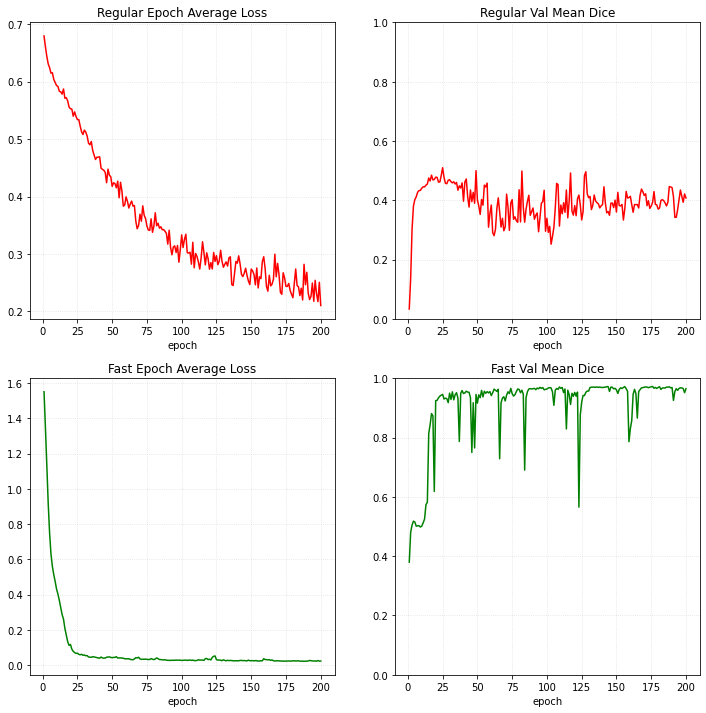

In [18]:
plt.figure("train", (12, 12))
plt.subplot(2, 2, 1)
plt.title("Regular Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 2)
plt.title("Regular Val Mean Dice")
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 3)
plt.title("Fast Epoch Average Loss")
x = [i + 1 for i in range(len(m_epoch_loss_values))]
y = m_epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")

plt.subplot(2, 2, 4)
plt.title("Fast Val Mean Dice")
x = [i + 1 for i in range(len(m_metric_values))]
y = m_metric_values
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")
plt.show()

## Plot total time and every epoch time

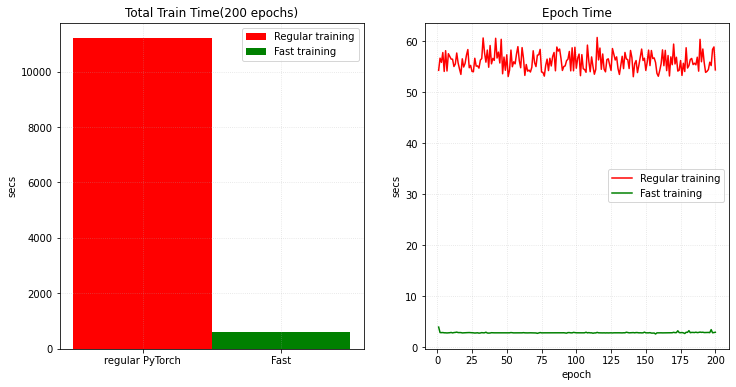

In [19]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Total Train Time(200 epochs)")
plt.bar(
    "regular PyTorch", total_time, 1, label="Regular training", color="red"
)
plt.bar("Fast", m_total_time, 1, label="Fast training", color="green")
plt.ylabel("secs")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Epoch Time")
x = [i + 1 for i in range(len(epoch_times))]
plt.xlabel("epoch")
plt.ylabel("secs")
plt.plot(x, epoch_times, label="Regular training", color="red")
plt.plot(x, m_epoch_times, label="Fast training", color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")
plt.show()

## Plot total time to achieve metrics

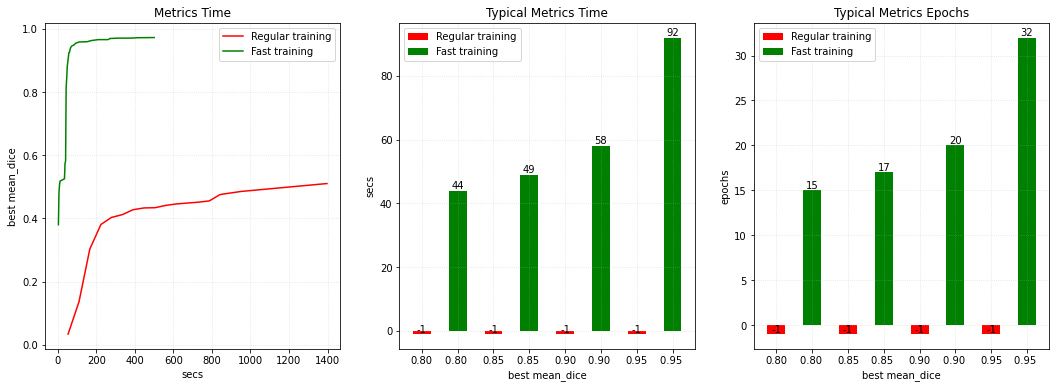

In [35]:
def get_best_metric_time(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if v > threshold:
            return best_values[2][i]
    return -1


def get_best_metric_epochs(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if v > threshold:
            return best_values[1][i]
    return -1


def get_label(index):
    if index == 0:
        return "Regular training"
    elif index == 1:
        return "Fast training"
    else:
        return None


plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Metrics Time")
plt.xlabel("secs")
plt.ylabel("best mean_dice")
plt.plot(best[2], best[0], label="Regular training", color="red")
plt.plot(m_best[2], m_best[0], label="Fast training", color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 3, 2)
plt.title("Typical Metrics Time")
plt.xlabel("best mean_dice")
plt.ylabel("secs")
labels = ["0.80", "0.80 ", "0.85", "0.85 ", "0.90", "0.90 ", "0.95", "0.95 "]
x_values = [0.8, 0.8, 0.85, 0.85, 0.9, 0.9, 0.95, 0.95]
for i, (l, x) in enumerate(zip(labels, x_values)):
    value = int(get_best_metric_time(x, best if i % 2 == 0 else m_best))
    color = "red" if i % 2 == 0 else "green"
    plt.bar(l, value, 0.5, label=get_label(i), color=color)
    plt.text(l, value, "%s" % value, ha="center", va="bottom")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 3, 3)
plt.title("Typical Metrics Epochs")
plt.xlabel("best mean_dice")
plt.ylabel("epochs")
for i, (l, x) in enumerate(zip(labels, x_values)):
    value = int(get_best_metric_epochs(x, best if i % 2 == 0 else m_best))
    color = "red" if i % 2 == 0 else "green"
    plt.bar(l, value, 0.5, label=get_label(i), color=color)
    plt.text(l, value, "%s" % value, ha="center", va="bottom")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)